# TIME SERIES ANALYSIS PART 2

# Goal: Find periodicity in the MTA turnstyle data

<bl> created by Federica Bianco 
<bl> modified by Eve Marenghi December 2018

Populating the interactive namespace from numpy and matplotlib


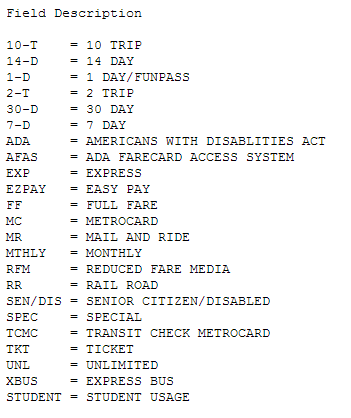

In [1]:
# import packages 
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from heapq import nlargest

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

# Read in data 

In [2]:
# read in the data 
mta = np.load("MTA_Fare.npy")

In [3]:
# check shape of the data 
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [4]:
# ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [5]:
# convert -1 values to nans
mta = mta.astype('float')
mta[mta == -1] = np.nan

In [6]:
# create a daterange 
dates = pd.date_range(start='05/19/2010', periods=194, freq='W')

Text(0.5,0.98,'Figure 1: Time Series for all Card Types and All Stations in NYC in Natural and Log space')

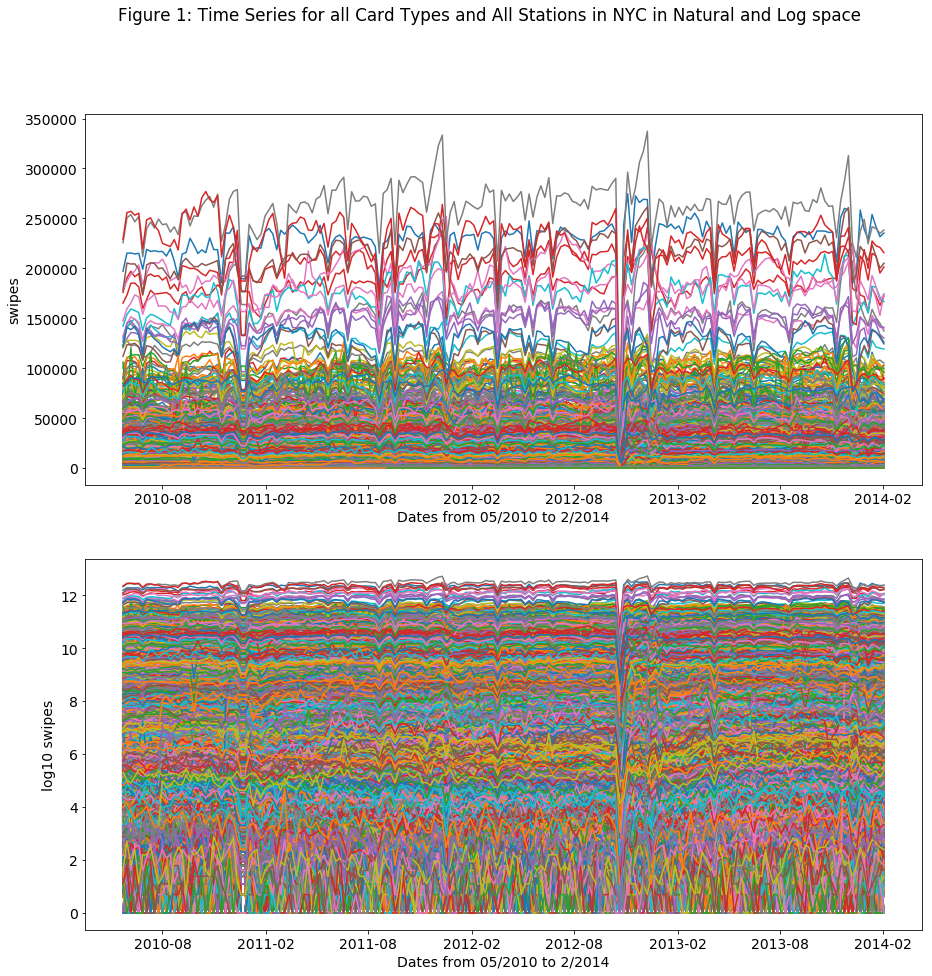

In [7]:
# plot the data in natural and log space  
# this code came from Ursula 

plt.rcParams.update({'font.size':14})
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
ax1.set(xlabel='Dates from 05/2010 to 2/2014', ylabel='swipes')
for i in range(len(mta)):
    for j in range(len(mta[i])):
        ax1.plot(dates, mta[i][j])
ax2.set(xlabel='Dates from 05/2010 to 2/2014', ylabel='log10 swipes')
for i in range(len(mta)):
    for j in range(len(mta[i])):
        ax2.plot(dates, np.log(mta[i][j]))
plt.suptitle('Figure 1: Time Series for all Card Types and All Stations in NYC in Natural and Log space')       

**Figure 1**: Time Series of swipes for all Card Types and All Stations in NYC in Natural and Log space. The top plot is the time series in natual space. There is a lot of variability in the number of swipes per card type - some card types have a high number of swipes and some have a very low number of swipes. There appears to be some periodicity in the time series. There is a large drop in swipes for all card types between 8/12 and 02/13. The bottom plot is the time series in log10 space. I converted to log space because swipes are distributed unevenly between the card types. The plot is more attractive to visualize when the y axis is in log space. In the log plot it's clear that there is a drop in the number of swipes for all card types between 8/12 and 02/13.

# 4. Fourier transform 
**Task**: Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [8]:
# we want to identify the 4 stations that show the most prominent periodic trend on an annual period (52 weeks)
# collapse on station 
stations = np.nansum(mta, axis = 1)
# check shape of stations, should be 600 stations by 194 weeks 
stations.shape

(600, 194)

In [9]:
# convert to a dataframe
# columns correspond to weeks
# rows correspond to stations 
stations_df = pd.DataFrame(stations, columns=pd.date_range(start='05/19/2010', periods=194, freq='W'))

To detect periodicity, use the "power spectrum". The power spectrum is the square (or absolute value) of the real part of the fourier transform.

In [10]:
# define sample_rate, duration, and N
sample_rate = 1 # 1 measurement per week 
duration = 194 # 194 weeks
N = sample_rate * duration

Text(0.5,1,'Power Spectrum of Swipes for all 600 Stations')

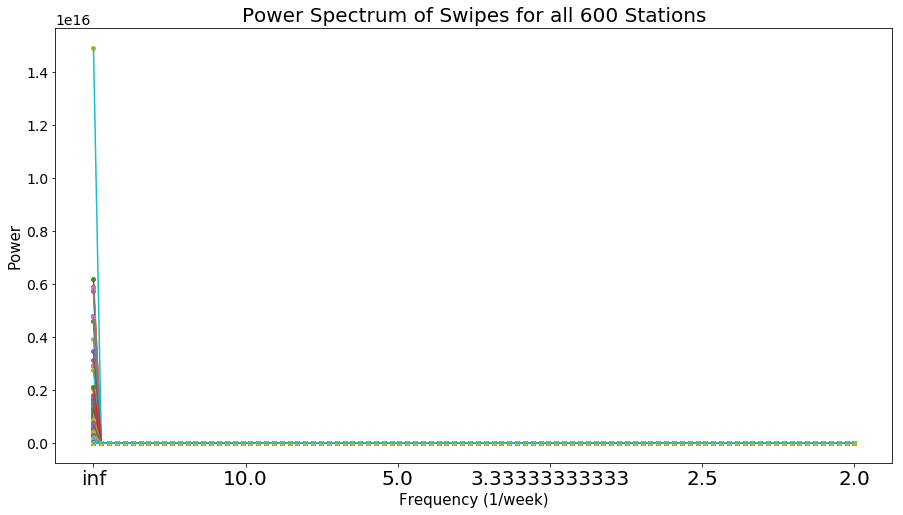

In [11]:
# plot power vs. frequency
# frequency is 1 / week
fig = pl.figure(figsize=(15,8))
ax = fig.add_subplot(111)

# plot power for all 600 stations 
for i in range(600):
    # take the absolute value of the FFT to suppress imaginary term and get a positive power 
    # (Same as using .real) - the power is the real term 
    f = np.abs(np.fft.rfft(stations[i]))**2
    ax.plot(np.fft.rfftfreq(N, 1.0), (f), 'o', ms=4)
    ax.plot(np.fft.rfftfreq(N, 1.0), (f), '-')

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.ylabel("Power", fontsize=15)
pl.xlabel("Frequency (1/week)", fontsize=15)
pl.title("Power Spectrum of Swipes for all 600 Stations", fontsize=20)

**Figure 2**: Power spectrum of swipes for all 600 subway stations. The y axis is power (square of the real part of the fourier transform) and x axis is frequency, which in this case is 1 / week. This graph is very hard to interpret and basically gives no information because the first point is time = 0, and when we divide 1 by 0 we get infinity which causes the plot to blow up on the y axis. 

**Discussion**:
What is on the x-axis of the FFT? The FT is calculated at: 

xax = [0, 1, ..., N/2-1, (N)/2] / (d*n)

(xax = [0, 1, ..., N/2-1, (N-1)/2] / (dn) of n is odd) in units of inverse frequency where n is the size of the input array and d is the sample spacing: what is the distance between datapoints in the input array in units of weeks. The sample spacing here is 1 (1 measurement per week).
To get the FREQUENCY on the x axis, take 1.0/xax


## Identify which frequencies should be removed from the power spectrum and calculate the Nyquist frequency

In [12]:
# find which frequencies we should remove 
print (" The first two frequency (slowest) caculated are \n1: infinity (1.0/0) ",
       "and \n2:the frequency corresponding to the entire duration of the series = N*d,"
       " \nand they should be removed because they are uninteresting\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[0], "= period: ", 1.0/np.fft.rfftfreq(N, 1.0)[0], "and\n",
       "freq: ", np.fft.rfftfreq(N, 1.0)[1], "= period: every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[1]), "weeks\n\n")

# find the Nyquist frequency 
print ("The fastest frequency you can calculate is every 1.0/2*d, "
       "called the Nyquist frequency\n",
       np.fft.rfftfreq(N, 1.0)[-1],  "or every %.1f"%(1.0/np.fft.rfftfreq(N, 1.0)[-1]), "weeks")

 The first two frequency (slowest) caculated are 
1: infinity (1.0/0)  and 
2:the frequency corresponding to the entire duration of the series = N*d, 
and they should be removed because they are uninteresting
 freq:  0.0 = period:  inf and
 freq:  0.00515463917526 = period: every 194.0 weeks


The fastest frequency you can calculate is every 1.0/2*d, called the Nyquist frequency
 0.5 or every 2.0 weeks


In [13]:
# find the frequency that correspond to 52 weeks (52 weeks in a year, we're looking for annual periodicity)
f_annual = 1 / np.fft.rfftfreq(194, 1.0)
print(f_annual)

[          inf  194.           97.           64.66666667   48.5          38.8
   32.33333333   27.71428571   24.25         21.55555556   19.4
   17.63636364   16.16666667   14.92307692   13.85714286   12.93333333
   12.125        11.41176471   10.77777778   10.21052632    9.7
    9.23809524    8.81818182    8.43478261    8.08333333    7.76
    7.46153846    7.18518519    6.92857143    6.68965517    6.46666667
    6.25806452    6.0625        5.87878788    5.70588235    5.54285714
    5.38888889    5.24324324    5.10526316    4.97435897    4.85
    4.73170732    4.61904762    4.51162791    4.40909091    4.31111111
    4.2173913     4.12765957    4.04166667    3.95918367    3.88
    3.80392157    3.73076923    3.66037736    3.59259259    3.52727273
    3.46428571    3.40350877    3.34482759    3.28813559    3.23333333
    3.18032787    3.12903226    3.07936508    3.03125       2.98461538
    2.93939394    2.89552239    2.85294118    2.8115942     2.77142857
    2.73239437    2.69444444   

The frequency that's closest to 52 weeks from the array above is 48.5. 48.5 is the 4th element in the array. Record the 4th periodicity value for each station so that we can identify the most prominent periodic trend on an annual basis.

Text(0.5,1,'Power Spectrum of Swipes for all 600 Stations')

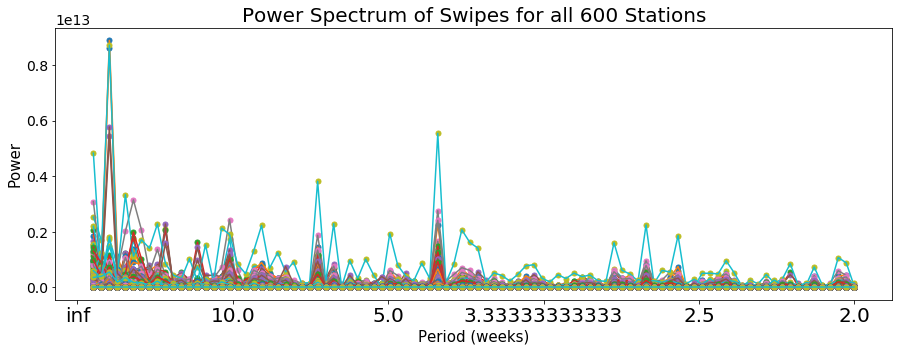

In [14]:
# remove the first two entries of the FFT output array because they are not physically interesting and they are 
# large numbers which forces the range of the y axis to be large. By plotting the points [2:], i.e. the FFT 
# omitting its first two values, the plot is easier to visualize 

fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

# create a dictionary to hold the periodicities so that we can identify stations with the most prominent 
# periodic trend 
period_dict = {}

for i in range(600):
    # get the periodicity for each station 
    f = np.abs(np.fft.rfft(stations[i]))**2
    # plot the periodicity for each station 
    ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), '-')
    # add periodicity for each station to the dictionary so we can identify most prominent later 
    period_dict[i] = f[4]

ax.set_xticklabels(["%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)
pl.title("Power Spectrum of Swipes for all 600 Stations", fontsize=20)

**Figure 3**: Power spectrum of swipes for all 600 subway stations with first two entries of the FFT output array removed. The y axis is power (square of the real part of the fourier transform) and x axis is period, which in this case is weeks. Removing the first two entries, which had very large power values, makes the plot easier to visualize. We can now see that the time series for each station do indeed have trends and periodicity. Further investigation is needed to identify which four stations have the most prominent annual periodicity.

In [15]:
# get the four largest periodicity values from the dictionary to identify the stations with the most prominent 
# periodic trend 
# nlargest code came from: https://www.w3resource.com/python-exercises/dictionary/python-data-type-dictionary-exercise-22.php
top4 = nlargest(4, period_dict, key=period_dict.get)
print("Four stations with most prominent annual periodic trend:", top4) 

Four stations with most prominent annual periodic trend: [0, 194, 150, 327]


Text(0.5,1,'Power Spectrum of Swipes for 4 Stations with Most Prominent Periodic Trends')

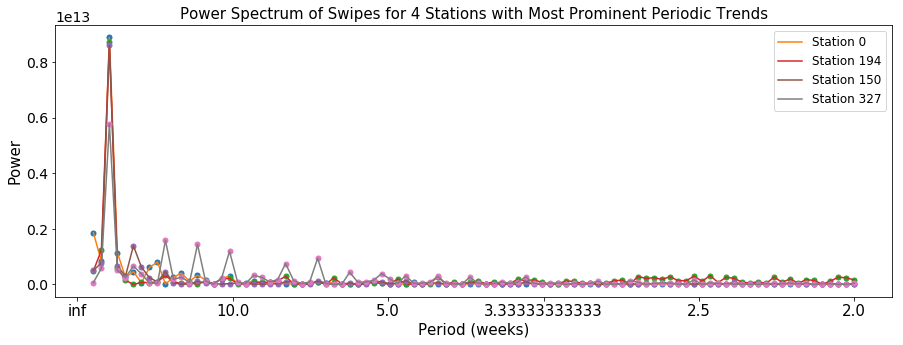

In [16]:
# plot the time series for the four stations with the most prominent periodic trends for further investigation  
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(len(top4)):
    # calculate the power 
    f = np.abs(np.fft.rfft(stations[top4[i]]))**2
    # plot 
    ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), '-', label="Station " + str(top4[i]))

ax.legend(fontsize=12)
ax.set_xticklabels(["%s"%(1/f) for f in ax.get_xticks()], fontsize=15)
pl.xlabel("Period (weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)
pl.title("Power Spectrum of Swipes for 4 Stations with Most Prominent Periodic Trends", fontsize=15)

**Figure 4**: Power spectrum of swipes for the four MTA stations with the most prominent periodic trends. The y axis is power (square of the real part of the fourier transform) and x axis is period, which in this case is weeks. I identified the 4 stations with the most prominent annual periodic trend by taking the stations with the four largest values from the dictionary I created that was holding the periodicity values for each station. This plot is helpful for distinguishing the stations with the four most prominent trends from the plot above that shows all 600 stations. However, the time series need to be plotted again with date on the x axis so that we can see the time of year when the time series are peaking and identify what might be causing the periodicity.

(array([ 733985.,  734169.,  734350.,  734534.,  734716.,  734900.,
         735081.,  735265.]), <a list of 8 Text xticklabel objects>)

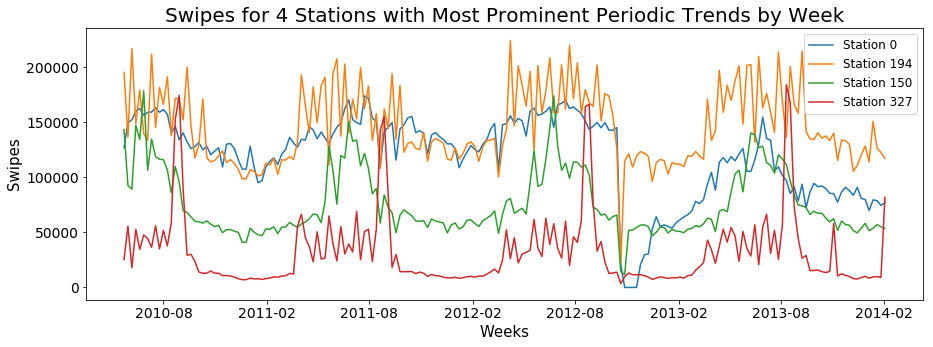

In [17]:
# Plotting the station swipes and dates to try to find possible events that explain the preiodicity
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

for i in range(len(top4)):
    ax.plot(dates, stations[top4[i]], '-', label="Station " + str(top4[i]))
    
pl.xlabel("Weeks", fontsize=15)
pl.ylabel("Swipes", fontsize=15)
ax.legend(loc='best', fontsize=12)
pl.title("Swipes for 4 Stations with Most Prominent Periodic Trends by Week", fontsize=20)
pl.xticks()

**Figure 5**: Number of swipes by week for the four stations with the most prominent periodic trends. The four stations with the most prominent periodic trends are stations 0, 194, 150, and 327. The increases in swipes for these four stations occur in the summer months. These are probably stations that people use frequently in the summer and use less frequently during other times of the year. We know that these stations are all in Manhattan. These stations could be in or near Central Park because Central Park is very popular during the summer. There are often events in Central Park during the summer, like Shakespeare in the Park (see https://www.events12.com/newyork/august/). 